In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import stats_by_epoch, plot_stats_ep

In [8]:
cats_dir = '/home/rt2122/Data/detected_cats/act_ros_rot/'
cats_files = next(os.walk(cats_dir))[-1]

In [26]:
def extract_stats_from_df(df_name):
    import numpy as np
    import pandas as pd
    
    df = pd.read_csv(df_name)
    
    stat_df = {}
    stat_df['all'] = len(df)
    stat_df['all_tp'] = np.count_nonzero(df['status'] == 'tp')
    stat_df['all_fn'] = np.count_nonzero(df['status'] == 'fn')
    stat_df['fp'] = np.count_nonzero(df['status'] == 'fp')
    
    for cat in set(df['catalog']):
        if not (type(cat) == type('')):
            continue
        
        cur_df = df[df['catalog'] == cat]
        cur_df.index = np.arange(len(cur_df))
            
        stat_df[cat+'_tp'] = np.count_nonzero(cur_df['status'] == 'tp')
        stat_df[cat+'_fn'] = np.count_nonzero(cur_df['status'] == 'fn')
        stat_df[cat+'_recall'] = stat_df[cat+'_tp'] / len(cur_df)
    
    return stat_df

In [29]:
def stats_by_epoch(dir_name):
    import os
    import pandas as pd
    import numpy as np
    from DS_data_transformation import get_prm
    
    res_df = []
    
    files = next(os.walk(dir_name))[-1]
    for file in files:
        stat_line = extract_stats_from_df(os.path.join(dir_name, file))
        ep = int(get_prm('ep', file))
        res_df.append(pd.DataFrame(stat_line, index=[ep]))
        
    return pd.concat(res_df)

In [2]:
stats_rot = stats_by_epoch('/home/rt2122/Data/detected_cats/act_ros_rot/')

In [106]:
def plot_stats_ep(stats_df, hist_file, text='', text_coords=[0,0]):
    import pandas as pd
    import numpy as np
    import pickle
    from matplotlib import pyplot as plt
    
    stats_df = stats_df.sort_index()
    cats_colors = {'planck_z' : 'b', 'planck_no_z' : 'g', 'mcxcwp' : 'r', 'actwp' : 'c'}
    metr_colors = {'iou' : 'r', 'dice' : 'b', 'loss' : 'c'}
    
    fig, ax = plt.subplots(3, 1, figsize=(12,12), sharex=True)
    plt.subplots_adjust(hspace=0.05)
    
    ####         recalls         ####
    for cat in cats_colors:
        line, = ax[0].plot(stats_df.index, stats_df[cat+'_recall'], cats_colors[cat]+'o-',
                          markersize=5)
        line.set_label(cat)
        
    ####         fp              ####
    line, = ax[1].plot(stats_df.index, stats_df['fp'], 'ko-', markersize=5)
    line.set_label('fp')
    
    ####        history          ####
    hist = None
    with open(hist_file, 'rb') as f:
        hist = pd.DataFrame(pickle.load(f), index=stats_df.index)
    for metr in metr_colors:
        line, = ax[2].plot(hist.index, hist[metr], metr_colors[metr]+'o-',
                          markersize=5)
        line.set_label(metr)
    
    #### ticks, grid, labels, legend ####
    ax[0].set_yticks(np.arange(0, 1.1, 0.1), minor=True)
    ax[0].set_yticks(np.arange(0, 1.1, 0.2))
    ax[1].set_yticks(np.arange(0, max(stats_df['fp']), 50), minor=True)
    ax[1].set_yticks(np.arange(0, max(stats_df['fp']), 100))
    
    for i in range(3):
        ax[i].legend()
        ax[i].set_xticks(stats_df.index[4::5])
        ax[i].set_xticks(stats_df.index, minor=True)
        ax[i].grid(True, which='major')
        ax[i].grid(True, which='minor', alpha=0.2)
    
    ax[2].set_xlabel('epochs')
    ax[0].set_ylabel('recall')
    ax[1].set_ylabel('fp')
    ax[2].set_ylabel('metrics')
    ax[1].text(*text_coords, text, c='r', size=20)
    
    


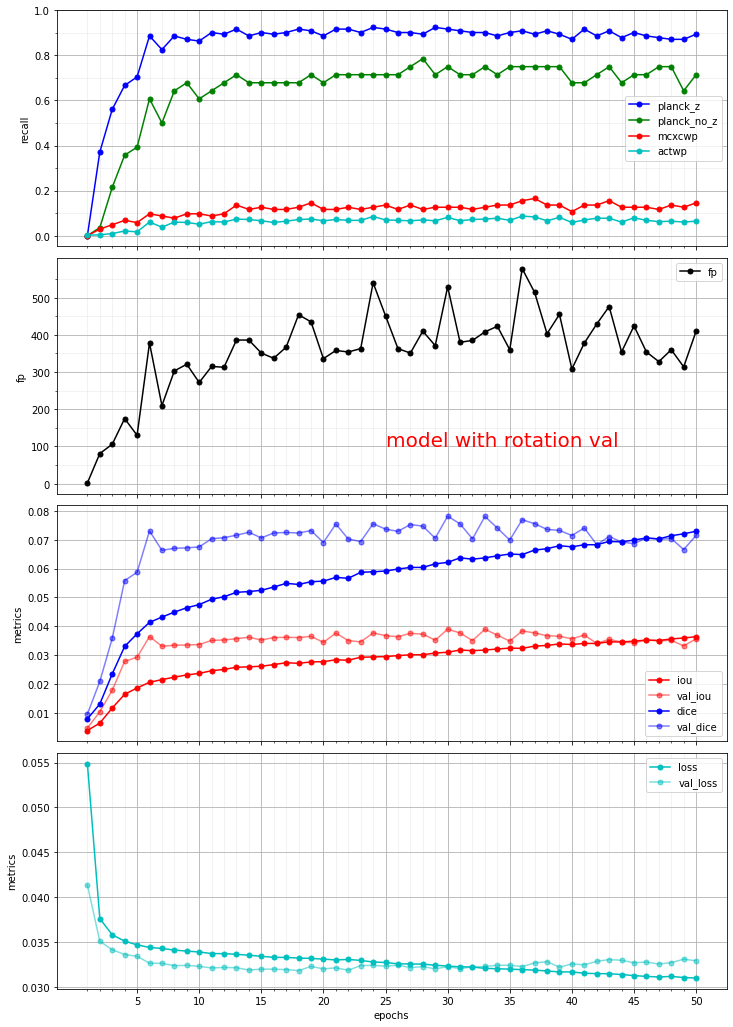

In [3]:
plot_stats_ep(stats_rot, '/home/rt2122/Data/detected_cats/act_ros_rot/tmp/act_ros_rot.ep1-50.history', 
              text='model with rotation val', text_coords=[25, 100])